In [1]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "4"

import tensorflow as tf
print(tf.__version__)

import tensorflow_probability as tfp
tfp.__version__

2.5.0


'0.12.2'

In [2]:
%pylab inline
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, NFWProfile
from diffhod.utils import *

from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

Populating the interactive namespace from numpy and matplotlib
2.5.0


In [3]:
# choosing subvolume so we can play around easier with derivatives

# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]


halo_table = halo_table[halo_table['halo_x'] < 128]
halo_table = halo_table[halo_table['halo_y'] < 128]
halo_table = halo_table[halo_table['halo_z'] < 128]
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

In [4]:
from diffhod.utils import *

In [5]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =-0.003, 
                                        modulate_with_cenocc=True)

# Here is how we define the same model in diffhod
@tf.function
def helper_hod(halo_cat, max_sat=60, temp=0.00001, params = zheng07_model.param_dict):

  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      **params,
                      temperature=temp)
  
  n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
                                      n_cen,
                                      **params,
                                      sample_shape=(max_sat,),
                                      temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))
    
  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                        concentration=halo_cat['halo_nfw_conc'],
                        Rvir=halo_cat['halo_rvir'],
                        sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen, 'pos_sat':pos_sat, 'n_cen':n_cen, 'n_sat':n_sat}

# sampling galaxies from the model

gal_cat = helper_hod(tf_halocat)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


In [6]:
# Same thing with halotools
zheng07_model.populate_mock(halocat) 

In [8]:
bs = 128
#DHOD selected
sample1 = gal_cat['pos_cen']/128*bs
sample1_r = tf.tile(tf.expand_dims(sample1,0),[1,1,1])

sample2 = tf.reshape(gal_cat['pos_sat'], [-1,3])/128*bs
sample2_r = tf.tile(tf.expand_dims(sample2,0),[1,1,1])

#HOD selected

# Let's define halotools samples
ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                       zheng07_model.mock.galaxy_table['y'],
                                       zheng07_model.mock.galaxy_table['z'])
m = zheng07_model.mock.galaxy_table['host_centric_distance'] <0.0001

#cutting same subvolume
ht_cens = ht_sample[m]
ht_cens = ht_cens[ht_cens[:,0]<128] 
ht_cens = ht_cens[ht_cens[:,1]<128] 
ht_cens = ht_cens[ht_cens[:,2]<128] 

ht_sats = ht_sample[~m]
ht_sats = ht_sats[ht_sats[:,0]<128] 
ht_sats = ht_sats[ht_sats[:,1]<128] 
ht_sats = ht_sats[ht_sats[:,2]<128] 

#DHOD painted
painted_central_tf =cic_paint(tf.zeros((1, bs, bs, bs)),sample1_r,weight=gal_cat['n_cen'])
painted_sat_tf =cic_paint(tf.zeros((1, bs, bs, bs)),sample2_r,weight=tf.reshape(gal_cat['n_sat'], [-1,]))

#hod painted
painted_central_hod = cic_paint(tf.zeros((1, bs, bs, bs)),ht_cens.reshape(1,-1,3)/128*bs)
painted_sat_hod = cic_paint(tf.zeros((1, bs, bs, bs)),ht_sats.reshape(1,-1,3)/128*bs)

centrals


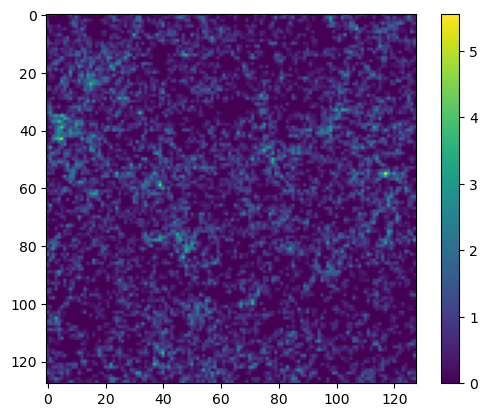

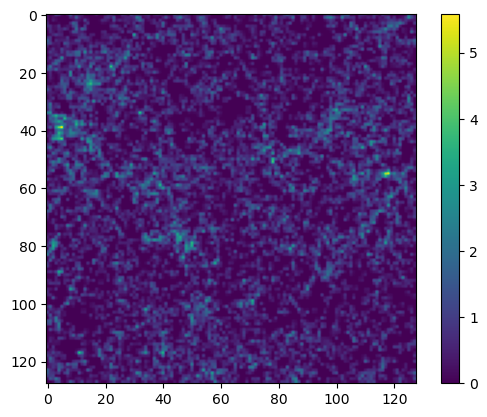

sats


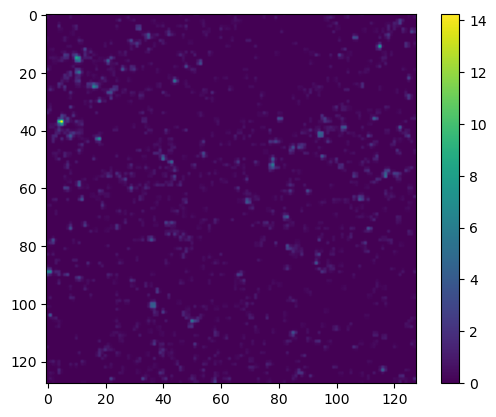

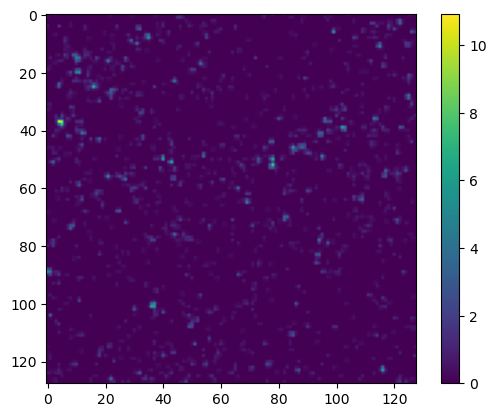

In [9]:
print("centrals")
imshow(np.array(painted_central_tf[0]).sum(axis=0))
colorbar()
show()

imshow(np.array(painted_central_hod[0]).sum(axis=0))
colorbar()
show()
print("sats")

imshow(np.array(painted_sat_tf[0]).sum(axis=0))
colorbar()
show()

imshow(np.array(painted_sat_hod[0]).sum(axis=0))
colorbar()
show()

In [10]:
from diffhod.mock_observables.pk import Power_Spectrum

In [11]:
pk = Power_Spectrum([128,128,128],[128,128,128], 0.01, 0.2)

In [12]:
karray, pkarray = pk.pk_tf(painted_sat_hod+painted_central_hod)
karray_tf, pkarray_tf = pk.pk_tf(painted_sat_tf+painted_central_tf)

Instructions for updating:
Use fn_output_signature instead


Text(0.5, 0, 'k')

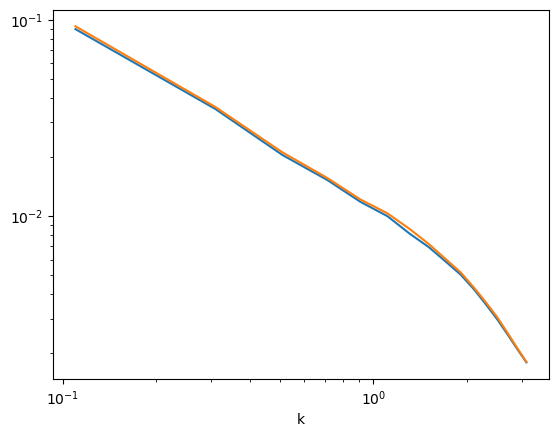

In [13]:
plt.loglog(karray, pkarray[0])
plt.loglog(karray_tf, pkarray_tf[0])
plt.xlabel(r"k")

In [14]:
#very inefficient loop! should be done easier since things are batch capable, but too lazy to debug...
pk_tf_array = []
pk_hod_array = []

pk_tf_array_sat = []
pk_hod_array_sat = []

pk_tf_array_cen = []
pk_hod_array_cen = []

samples = 500

for samp in range(0,samples):
    print(samp)
    # Sample DHOD
    gal_cat = helper_hod(tf_halocat)
    # Same thing with halotools
    zheng07_model.populate_mock(halocat) 
    
    
    bs = 128
    #DHOD selected
    sample1 = gal_cat['pos_cen']/128*bs
    sample1_r = tf.tile(tf.expand_dims(sample1,0),[1,1,1])

    sample2 = tf.reshape(gal_cat['pos_sat'], [-1,3])/128*bs
    sample2_r = tf.tile(tf.expand_dims(sample2,0),[1,1,1])

    #HOD selected

    # Let's define halotools samples
    ht_sample = return_xyz_formatted_array(zheng07_model.mock.galaxy_table['x'],
                                           zheng07_model.mock.galaxy_table['y'],
                                           zheng07_model.mock.galaxy_table['z'])
    m = zheng07_model.mock.galaxy_table['host_centric_distance'] <0.0001

    #cutting same subvolume
    ht_cens = ht_sample[m]
    ht_cens = ht_cens[ht_cens[:,0]<128] 
    ht_cens = ht_cens[ht_cens[:,1]<128] 
    ht_cens = ht_cens[ht_cens[:,2]<128] 

    ht_sats = ht_sample[~m]
    ht_sats = ht_sats[ht_sats[:,0]<128] 
    ht_sats = ht_sats[ht_sats[:,1]<128] 
    ht_sats = ht_sats[ht_sats[:,2]<128] 

    #DHOD painted
    painted_central_tf =cic_paint(tf.zeros((1, bs, bs, bs)),sample1_r,weight=gal_cat['n_cen'])
    painted_sat_tf =cic_paint(tf.zeros((1, bs, bs, bs)),sample2_r,weight=tf.reshape(gal_cat['n_sat'], [-1,]))

    #hod painted
    painted_central_hod = cic_paint(tf.zeros((1, bs, bs, bs)),ht_cens.reshape(1,-1,3)/128*bs)
    painted_sat_hod = cic_paint(tf.zeros((1, bs, bs, bs)),ht_sats.reshape(1,-1,3)/128*bs)
    
    
    karray, pkarray = pk.pk_tf(painted_sat_hod+painted_central_hod)
    karray_tf, pkarray_tf = pk.pk_tf(painted_sat_tf+painted_central_tf)
    
    pk_tf_array.append(pkarray_tf[0])
    pk_hod_array.append(pkarray[0])
    
    
        
    karray, pkarray = pk.pk_tf(painted_sat_hod)
    karray_tf, pkarray_tf = pk.pk_tf(painted_sat_tf)
    
    pk_tf_array_sat.append(pkarray_tf[0])
    pk_hod_array_sat.append(pkarray[0])
    
        
    karray, pkarray = pk.pk_tf(painted_central_hod)
    karray_tf, pkarray_tf = pk.pk_tf(painted_central_tf)
    
    pk_tf_array_cen.append(pkarray_tf[0])
    pk_hod_array_cen.append(pkarray[0])

0
1
2


KeyboardInterrupt: 

In [134]:
avg_all = np.mean(np.array(pk_hod_array),axis=0)
avg_cen = np.mean(np.array(pk_hod_array_cen),axis=0)
avg_sat = np.mean(np.array(pk_hod_array_sat),axis=0)

In [135]:
std_all = np.std(np.array(pk_hod_array),axis=0)
std_cen = np.std(np.array(pk_hod_array_cen),axis=0)
std_sat = np.std(np.array(pk_hod_array_sat),axis=0)


In [136]:
avg_all_tf = np.mean(np.array(pk_tf_array),axis=0)
avg_cen_tf = np.mean(np.array(pk_tf_array_cen),axis=0)
avg_sat_tf = np.mean(np.array(pk_tf_array_sat),axis=0)

std_all_tf = np.std(np.array(pk_tf_array),axis=0)
std_cen_tf = np.std(np.array(pk_tf_array_cen),axis=0)
std_sat_tf = np.std(np.array(pk_tf_array_sat),axis=0)


In [137]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

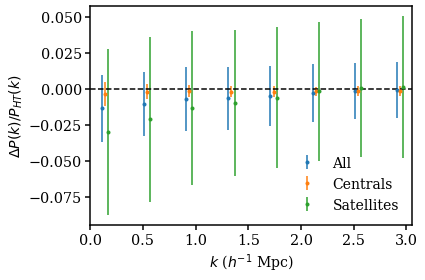

In [142]:
plt.errorbar(karray[::2],(avg_all[::2]-avg_all_tf[::2])/avg_all_tf[::2],yerr=std_all_tf[::2]/avg_all_tf[::2],fmt='.',label="All")
plt.errorbar(karray[::2]+0.03,(avg_cen[::2]-avg_cen_tf[::2])/avg_cen_tf[::2],yerr=std_cen_tf[::2]/avg_all_tf[::2],fmt='.',label="Centrals")
plt.errorbar(karray[::2]+0.06,(avg_sat[::2]-avg_sat_tf[::2])/avg_sat_tf[::2],yerr=std_sat_tf[::2]/avg_sat_tf[::2],fmt='.',label="Satellites")
plt.ylabel("$\Delta P(k)/P_{HT}(k)$",fontsize=14)
plt.xlabel("$k$ ($h^{-1}$ Mpc)",fontsize=14)

plt.plot([0,karray[-1]+0.06],[0,0], "k--")
#show()

plt.xlim(0,3.05)
legend(loc=4,fontsize=14)

tight_layout()
plt.savefig("ps_error.pdf")
#plt.errorbar(karray,(avg_all-avg_all_tf)/avg_all_tf,yerr=np.sqrt(std_all_tf**2)/avg_all_tf)